In [1]:
%matplotlib notebook
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from celluloid import Camera
from IPython.display import HTML
import torchio as tio
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from model import U_Net
import matplotlib.pyplot as plt
import numpy as np
import glob


from tqdm.notebook import tqdm

In [2]:
def change_img_to_label_path(path):
    
    parts = list(path.parts)
    parts[parts.index("image")] = "mask"
    return Path(*parts)

In [3]:
path = Path("T2/image/")
subjects_paths = list(path.glob("image_*"))
subjects = []

for subject_path in subjects_paths:
    label_path = change_img_to_label_path(subject_path)
    subject = tio.Subject({"MR":tio.ScalarImage(subject_path), "Label":tio.LabelMap(label_path)}) 
    #print(np.unique(label))
    subjects.append(subject)

In [4]:
for subject in subjects:
    assert subject["MR"].orientation == ("L", "P", "S")

In [5]:
process = tio.Compose([
            tio.CropOrPad((350, 350, 200)),
            tio.RescaleIntensity((-1, 1))
            ])


augmentation = tio.RandomAffine(scales=(0.9, 1.1), degrees=(-10, 10))


val_transform = process
train_transform = tio.Compose([process, augmentation])

In [6]:
train_dataset = tio.SubjectsDataset(subjects[:800], transform=train_transform)
val_dataset = tio.SubjectsDataset(subjects[800:], transform=val_transform)

sampler = tio.data.LabelSampler(patch_size=96, label_name="Label", label_probabilities={0:0.2, 1:0.3 , 3:0.5})

In [7]:
train_patches_queue = tio.Queue(
     train_dataset,
     max_length=50,
     samples_per_volume=5,
     sampler=sampler,
     num_workers=0
    )

val_patches_queue = tio.Queue(
     val_dataset,
     max_length=50,
     samples_per_volume=5,
     sampler=sampler,
    
     num_workers=0
    )

In [8]:
batch_size = 8

train_loader = torch.utils.data.DataLoader(train_patches_queue, batch_size=batch_size, num_workers=32)
val_loader = torch.utils.data.DataLoader(val_patches_queue, batch_size=batch_size, num_workers=32)

In [9]:
import random
class Segmenter(pl.LightningModule):
    def __init__(self):
        super().__init__()

        self.model = U_Net()

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.CrossEntropyLoss()


    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):

        
        img = batch["MR"]["data"]
        mask = batch["Label"]["data"][:,0]  
        mask = mask.long()
        mask = (mask > 0).long()
        pred = self(img)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Train Loss", loss)
        self.log("Train Loss per epoch", loss, on_step=False, on_epoch=True)
        if batch_idx % 50 == 0:
            self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Train")
        return loss


    def validation_step(self, batch, batch_idx):
        
        img = batch["MR"]["data"]
        mask = batch["Label"]["data"][:,0]  
        mask = mask.long()
        mask = (mask > 0).long()
        pred = self(img)
        loss = self.loss_fn(pred, mask)

        # Logs
        self.log("Val Loss", loss)
        self.log("Val Loss per epoch", loss, on_step=False, on_epoch=True)
        self.log_images(img.cpu(), pred.cpu(), mask.cpu(), "Val")

        return loss
    
    def on_epoch_end(self):
        
        self.model.to('cuda')

        
        train_sample = next(iter(self.train_dataloader()))
        val_sample = next(iter(self.val_dataloader()))

        
        train_img = train_sample["MR"]["data"].to('cuda')
        val_img = val_sample["MR"]["data"].to('cuda')
        train_label = train_sample["Label"]["data"][:, 0].to('cuda')
        val_label = val_sample["Label"]["data"][:, 0].to('cuda')

       
        self.log_images(train_img, self(train_img), train_label, "Train Epoch End")
        self.log_images(val_img, self(val_img), val_label, "Val Epoch End")


        
    def log_images(self, img, pred, mask, name):
        pred = torch.argmax(pred, 1) 
        axial_slice = 50  

        
        img_cpu = img.cpu()
        mask_cpu = mask.cpu()
        pred_cpu = pred.cpu()

        fig, axis = plt.subplots(1, 2)
        axis[0].imshow(img_cpu[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(mask_cpu[0][:,:,axial_slice] == 0, mask_cpu[0][:,:,axial_slice])
        axis[0].imshow(mask_, alpha=0.6)
        axis[0].set_title("Ground Truth")

        axis[1].imshow(img_cpu[0][0][:,:,axial_slice], cmap="bone")
        mask_ = np.ma.masked_where(pred_cpu[0][:,:,axial_slice] == 0, pred_cpu[0][:,:,axial_slice])
        axis[1].imshow(mask_, alpha=0.6, cmap="autumn")
        axis[1].set_title("Pred")

        plt.show()  
        self.logger.experiment.add_figure(f"{name} Prediction vs Label", fig, self.global_step)



    def configure_optimizers(self):
        return [self.optimizer]



In [10]:
model = Segmenter()
checkpoint_callback = ModelCheckpoint(
    monitor='Val Loss per epoch',
    save_top_k=5,
    mode='min')

In [11]:
gpus = 1 
trainer = pl.Trainer(gpus=gpus, logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=[checkpoint_callback],
                     max_epochs=40)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)

In [ ]:
####### trained weights

In [12]:
path = 'logs/default/version_6/checkpoints/epoch=33-step=29599.ckpt'
model = Segmenter.load_from_checkpoint(checkpoint_path=path)
trainer = pl.Trainer(gpus=1)
trainer.test(model=model, dataloaders=val_loader)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/bather/anaconda3/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a test_dataloader but have no test_step. Skipping test loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-04-13 16:11:29.442354: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 16:11:29.498624: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-13 16:11:29.499844: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow w

[]

In [13]:
model = model.eval()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device);

In [14]:
from IPython.display import HTML
from celluloid import Camera


In [15]:
IDX = 51
mask = val_dataset[IDX]["Label"]["data"]
imgs = val_dataset[IDX]["MR"]["data"]


grid_sampler = tio.inference.GridSampler(val_dataset[IDX], 96, (8, 8, 8))

In [16]:
imgs.shape

torch.Size([1, 350, 350, 200])

In [17]:
aggregator = tio.inference.GridAggregator(grid_sampler)
patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=12)

In [18]:
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['MR']["data"].to(device)  
        locations = patches_batch[tio.LOCATION]  
        pred = model(input_tensor)  
        aggregator.add_batch(pred, locations)  

/home/bather/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [19]:
output_tensor = aggregator.get_output_tensor()  

<IPython.core.display.Javascript object>


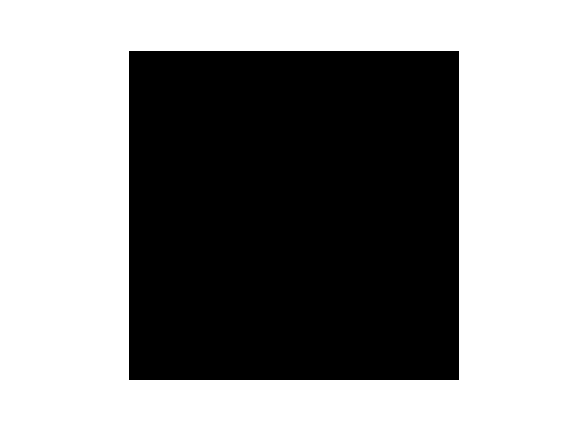

In [20]:
# axial
fig = plt.figure()
camera = Camera(fig)  
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[3], 2):  
    plt.imshow(imgs[0,:,:,i], cmap="bone")
    mask_ = np.ma.masked_where(pred[:,:,i]==0, pred[:,:,i])
    label_mask = np.ma.masked_where(mask[0,:,:,i]==0, mask[0,:,:,i])
    plt.imshow(mask_, alpha=0.5, cmap="gist_rainbow")
    plt.imshow(label_mask, alpha=0.4, cmap="bwr")  

    plt.axis("off")
    camera.snap()  
animation = camera.animate()  

In [21]:
HTML(animation.to_html5_video()) 

/home/bather/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/bather/anaconda3/lib/python3.9/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


<IPython.core.display.Javascript object>


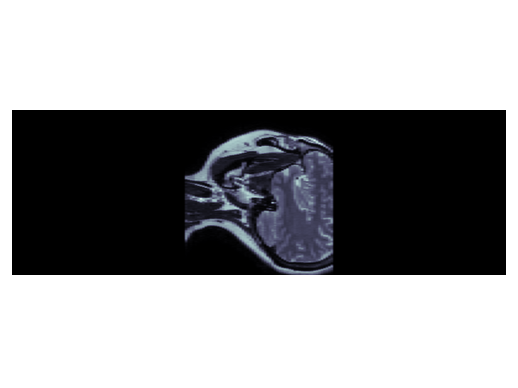

In [22]:
#sagittal
fig = plt.figure()
camera = Camera(fig)  
pred = output_tensor.argmax(0)

for i in range(-10, output_tensor.shape[1], 5):  
    plt.imshow(imgs[0,i,:,:], cmap="bone", aspect = 0.19 )
    mask_ = np.ma.masked_where(pred[i,:,:]==0, pred[i,:,:])
    label_mask = np.ma.masked_where(mask[0,i,:,:]==0, mask[0,i,:,:])
    plt.imshow(mask_, alpha=0.5, cmap="gist_rainbow", aspect = 0.19 )
    plt.imshow(label_mask, alpha=0.4, cmap="bwr", aspect = 0.19 )  

    plt.axis("off")
    camera.snap()  
    plt.tight_layout()
animation = camera.animate()  

<IPython.core.display.Javascript object>


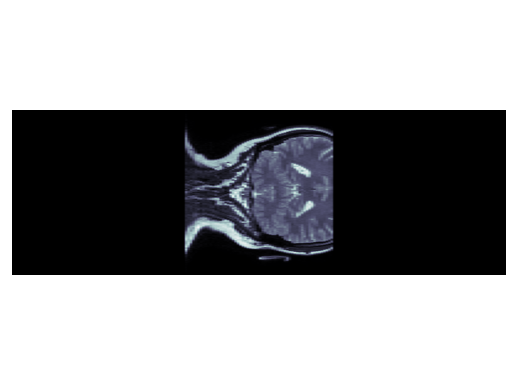

In [23]:
#coronal
fig = plt.figure()
camera = Camera(fig)  
pred = output_tensor.argmax(0)

for i in range(0, output_tensor.shape[2], 5):  
    plt.imshow(imgs[0,:,i,:], cmap="bone", aspect = 0.19 )
    mask_ = np.ma.masked_where(pred[:,i,:]==0, pred[:,i,:])
    label_mask = np.ma.masked_where(mask[0,:,i,:]==0, mask[0,:,i,:])
    plt.imshow(mask_, alpha=0.5, cmap="gist_rainbow", aspect = 0.19 )
    plt.imshow(label_mask, alpha=0.4, cmap="bwr", aspect = 0.19 )  

    plt.axis("off")
    camera.snap()  
    plt.tight_layout()
animation = camera.animate()  

In [24]:
class DiceScore(torch.nn.Module):
    """
    class to compute the Dice Loss
    """
    def __init__(self):
        super().__init__()

    def forward(self, pred, mask):
                
        
        pred = torch.flatten(pred)
        mask = torch.flatten(mask)
        
        counter = (pred * mask).sum()  # Counter       
        denum = pred.sum() + mask.sum()  # denominator
        dice = (2*counter)/denum
        
        return dice

In [25]:
pred = []
for i in range(1,65):
    mask = val_dataset[i]['Label']['data']
    img = val_dataset[i]['MR']['data']
    grid_sampler = tio.inference.GridSampler(val_dataset[i], 96, (8, 8, 8))
    aggregator = tio.inference.GridAggregator(grid_sampler)
    patch_loader = torch.utils.data.DataLoader(grid_sampler, batch_size=2)
    pred.append(patch_loader)

In [26]:
preds = []
labels = []
# Prediction
with torch.no_grad():
    for patches_batch in patch_loader:
        input_tensor = patches_batch['MR']["data"].to(device)  
        label = patches_batch['Label']["data"].to(device)
        pred = model(input_tensor)  
        preds.append(pred.cpu().numpy())
        labels.append(label.cpu().numpy())

/home/bather/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [27]:
dice_scores = []
dice_score_calculator = DiceScore()

for pred, label in zip(preds, labels):
    
    pred_tensor = torch.from_numpy(pred).float()
    label_tensor = torch.from_numpy(label).float()

    
    pred_tensor = pred_tensor[:, 1, ...]

    
    label_tensor = label_tensor.squeeze(1)

    
    assert pred_tensor.shape == label_tensor.shape

    
    dice_score = dice_score_calculator(pred_tensor, label_tensor)
    dice_scores.append(dice_score.item())


average_dice_score = sum(dice_scores) / len(dice_scores)

0.75816003
